In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
import tensorflow as tf
import seaborn as sns

In [2]:
plt.set_cmap('coolwarm')

<Figure size 432x288 with 0 Axes>

In [3]:
np.set_printoptions(threshold=10)
sigmoid = lambda x : 1 / (1 + np.exp(-x))

# Binary Classification

### Generating Bivariate Classification Data

In [4]:
def generate_classification_data(size, classes=2, angle=None, sep=1, noise=1, n_features=2):
    means = np.linspace(-sep, sep, classes) * classes
    X = np.concatenate([np.random.normal(loc=means[i], 
                                         scale=noise, 
                                         size=(size // classes, n_features)) for i in range(classes)], axis=0)
    y = np.concatenate([np.zeros(size // classes) + i for i in range(classes)], axis=0)
    angle = angle if angle else np.random.randint(0, 181)
    theta = np.pi / 180 * angle
    R = np.array([[np.cos(theta), np.sin(theta)], [-np.sin(theta), np.cos(theta)]])
    X = X @ R
    return X, y

In [5]:
X, y = generate_classification_data(500, noise=1.75)

In [6]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [7]:
print("X_train shape : ", X_train.shape)
print("X_test shape : ", X_test.shape)
print("y_train shape : ", y_train.shape)
print("y_test shape : ", y_test.shape)

X_train shape :  (400, 2)
X_test shape :  (100, 2)
y_train shape :  (400,)
y_test shape :  (100,)


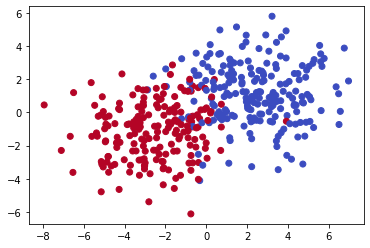

In [8]:
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train)

### Logistic Regression  Model for Binary Classification

In [11]:
class BinaryClassifier:
    def __init__(self, n_features, degree=1, weights=None, normalize=True, threshold=0.5):
        self.__n_features = n_features
        self.__degree = degree
        self.weights = weights if np.sum(weights) else np.random.randn(n_features * degree + 1) 
        self.__normalize = normalize
        self.__scaling_params = (0, 1)
        self.__threshold = threshold
        self.metrics = None
            
    def __transform(self, X, training=False, normalize=True):
        X_init = X
        for i in range(2, self.__degree + 1):
            X = np.c_[X, X_init ** i]
        if training:
            self.__scaling_params = (X.mean(axis=0), X.std(axis=0))
        if self.__normalize:
            mu, s = self.__scaling_params
            X = (X - mu) / (s + 1e-9)
        return np.c_[np.ones((X.shape[0], 1)), X].T  
    
    def fit(self, X, y, epochs=1, batch_size=None, alpha=0.001, verbose=True):
        X = self.__transform(X, training=True)
        loss_per_epochs, acc_per_epochs = [], []
        for i in range(epochs):
            y_pred = sigmoid(self.weights.T @ X)
            J = -np.mean(y * np.log(y_pred + 1e-9) + (1 - y) * np.log(1 - y_pred + 1e-9))
            acc = np.mean((y_pred >= self.__threshold) == y)
            loss_per_epochs.append(J)
            acc_per_epochs.append(acc)
            self.weights -= alpha * np.mean((y_pred - y) * X, axis=1)            
            if verbose:
                print(f'Epoch {i+1}/{epochs}\n{X.shape[-1]}/{X.shape[-1]} [==============] : loss = {J:.6f}\t acc = {acc}')
        self.metrics= {'loss_per_epochs' : loss_per_epochs, 'acc_per_epochs' : acc_per_epochs}
        
    def predict(self, X, predict_classes=False):
        y_pred = sigmoid(self.weights.T @ self.__transform(X))
        if predict_classes:
            y_pred = y_pred >= self.__threshold
        return y_pred
    
    def evaluate(self, X, y, return_preds=False):
        y_pred = self.predict(X)
        J = -np.mean(y * np.log(y_pred + 1e-9) + (1 - y) * np.log(1 - y_pred + 1e-9))
        acc = np.mean((y_pred >= self.__threshold) == y)
        evaluation = {'loss' : J, 'accurracy' : acc}
        if return_preds:
            evaluation['predictions'] = y_pred
        return evaluation
    
    def get_weights(self, return_scaling_params=False):
        """returns weights as a dict object with keys - `weights` and `bias`"""
        model_weights = {'weights' : self.weights[1:], 'bias' : self.weights[0]}
        if return_scaling_params:
            model_weights['scaling_mean'], model_weights['scaling_std'] = self.__scaling_params
        return model_weights 
    
    def plot_decision_boundary(self, X, y, figsize=(7,7), ec='white', s=50,alpha=0.8):
        plt.figure(figsize=figsize)
        x1 = np.arange(X[:, 0].min() - 1, X[:, 0].max() + 1, 0.1)
        x2 = np.arange(X[:, 1].min() - 1, X[:, 1].max() + 1, 0.1)

        X1, X2 = np.meshgrid(x1, x2)
        X1, X2 = X1.ravel(), X2.ravel() 
        preds = model.predict(np.c_[X1, X2]).reshape(x2.shape[0], x1.shape[0])

        extent=[X[:, 0].min() - 1, X[:, 0].max() + 1, X[:, 1].min() - 1, X[:, 1].max() + 1]
        plt.imshow(preds, origin='lower', extent=extent, alpha=alpha, aspect='auto')
        plt.scatter(X[:, 0], X[:, 1], c=y, ec=ec, s=s)

### Training

In [12]:
model = BinaryClassifier(n_features=2)

In [13]:
model.fit(X_train, y_train, epochs=10, alpha=1)

Epoch 1/10
400/400 [==============] : loss = 0.555679	 acc = 0.695
Epoch 2/10
400/400 [==============] : loss = 0.427000	 acc = 0.835
Epoch 3/10
400/400 [==============] : loss = 0.360876	 acc = 0.8975
Epoch 4/10
400/400 [==============] : loss = 0.322274	 acc = 0.905
Epoch 5/10
400/400 [==============] : loss = 0.297182	 acc = 0.9225
Epoch 6/10
400/400 [==============] : loss = 0.279550	 acc = 0.925
Epoch 7/10
400/400 [==============] : loss = 0.266443	 acc = 0.925
Epoch 8/10
400/400 [==============] : loss = 0.256282	 acc = 0.925
Epoch 9/10
400/400 [==============] : loss = 0.248150	 acc = 0.925
Epoch 10/10
400/400 [==============] : loss = 0.241476	 acc = 0.925


Text(0.5, 1.0, 'Training Accuracy')

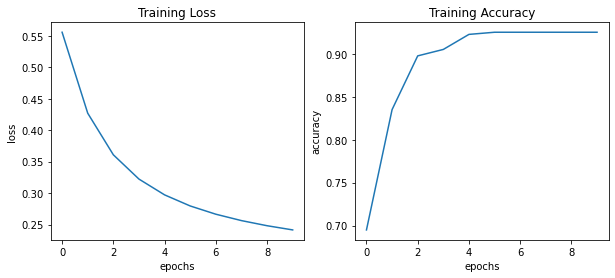

In [14]:
plt.figure(figsize=(10, 4))
plt.subplot(121)
plt.plot(model.metrics['loss_per_epochs'])
plt.xlabel('epochs')
plt.ylabel('loss')
plt.title('Training Loss')
plt.subplot(122)
plt.plot(model.metrics['acc_per_epochs'])
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.title('Training Accuracy')

In [15]:
min(model.metrics['loss_per_epochs'])

0.2414760463356189

In [16]:
model.get_weights()

{'weights': array([-1.99511485, -0.7155161 ]), 'bias': -0.19826093547571208}

### Evaluation

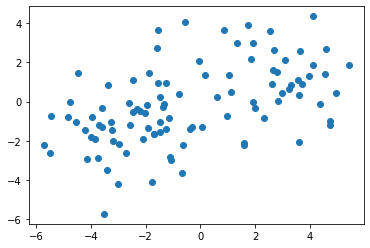

In [17]:
plt.scatter(X_test[:, 0], X_test[:, 1])

In [18]:
model.evaluate(X_test, y_test)

{'loss': 0.2004449945297089, 'accurracy': 0.97}

In [19]:
y_pred = model.predict(X_test, predict_classes=True)

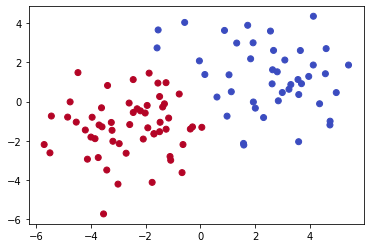

In [20]:
plt.scatter(X_test[:, 0], X_test[:, 1], c=y_pred)

### Decision Boundary

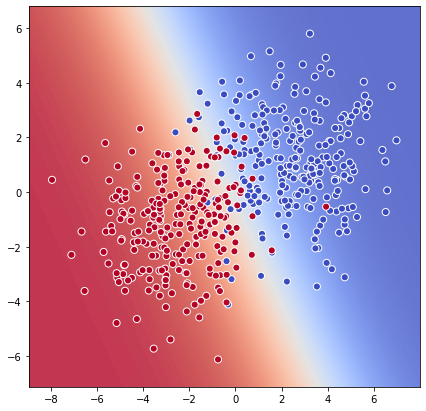

In [21]:
model.plot_decision_boundary(X, y)

---

### Generating Circular Classification Data

In [22]:
def generate_circular_data(size, classes=2, sep=5, noise=1.5, n_features=2, centre=0):
    x1 = np.linspace(-sep, sep, size // (2 * classes))
    x2 = np.sqrt(sep ** 2 - x1 ** 2) + np.random.randn(size // (2 * classes)) * (noise * sep / 10)
    X = np.r_[np.c_[x1, x2], np.c_[x1, -x2]]
    X = np.r_[X, np.random.normal(loc=centre, scale=noise, size=(size // classes, n_features))]                 
    y = np.concatenate([np.zeros(size // classes) + i for i in range(classes)], axis=0)
    return X, y

In [23]:
X, y = generate_circular_data(500)

In [24]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [25]:
print("X_train shape : ", X_train.shape)
print("X_test shape : ", X_test.shape)
print("y_train shape : ", y_train.shape)
print("y_test shape : ", y_test.shape)

X_train shape :  (400, 2)
X_test shape :  (100, 2)
y_train shape :  (400,)
y_test shape :  (100,)


(-5.5, 5.5, -7.43511366996591, 7.43511366996591)

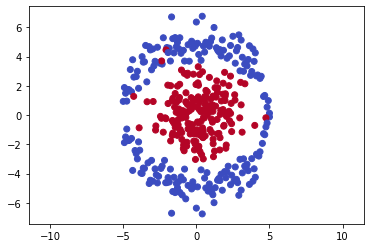

In [26]:
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train)
plt.axis('equal')

### Training

In [27]:
model = BinaryClassifier(n_features=2, degree=2)

In [28]:
model.fit(X_train, y_train, epochs=10, alpha=1)

Epoch 1/10
400/400 [==============] : loss = 0.808698	 acc = 0.7325
Epoch 2/10
400/400 [==============] : loss = 0.644526	 acc = 0.765
Epoch 3/10
400/400 [==============] : loss = 0.507967	 acc = 0.79
Epoch 4/10
400/400 [==============] : loss = 0.403870	 acc = 0.83
Epoch 5/10
400/400 [==============] : loss = 0.330994	 acc = 0.86
Epoch 6/10
400/400 [==============] : loss = 0.281617	 acc = 0.89
Epoch 7/10
400/400 [==============] : loss = 0.247558	 acc = 0.92
Epoch 8/10
400/400 [==============] : loss = 0.223159	 acc = 0.93
Epoch 9/10
400/400 [==============] : loss = 0.204965	 acc = 0.9475
Epoch 10/10
400/400 [==============] : loss = 0.190896	 acc = 0.955


Text(0.5, 1.0, 'Training Accuracy')

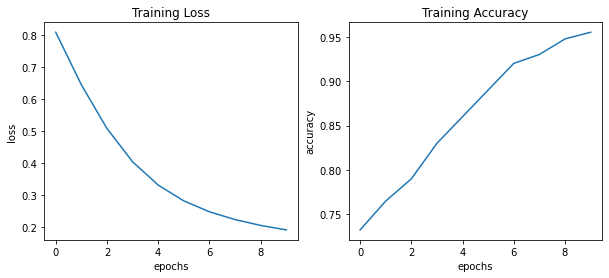

In [29]:
plt.figure(figsize=(10, 4))
plt.subplot(121)
plt.plot(model.metrics['loss_per_epochs'])
plt.xlabel('epochs')
plt.ylabel('loss')
plt.title('Training Loss')
plt.subplot(122)
plt.plot(model.metrics['acc_per_epochs'])
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.title('Training Accuracy')

In [30]:
min(model.metrics['loss_per_epochs'])

0.19089626779676563

In [31]:
model.get_weights()

{'weights': array([ 0.52522704, -0.23957569, -1.77828715, -2.00812923]),
 'bias': -0.0005353246034776431}

### Evaluation

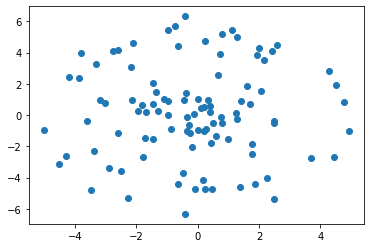

In [32]:
plt.scatter(X_test[:, 0], X_test[:, 1])

In [33]:
model.evaluate(X_test, y_test)

{'loss': 0.17760359502664744, 'accurracy': 0.96}

In [34]:
y_pred = model.predict(X_test, predict_classes=True)

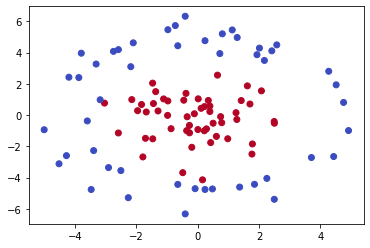

In [35]:
plt.scatter(X_test[:, 0], X_test[:, 1], c=y_pred)

### Decision Boundary

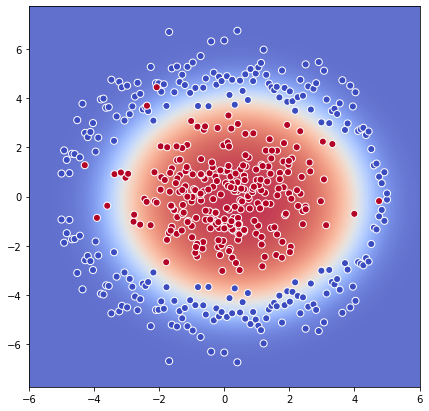

In [36]:
model.plot_decision_boundary(X, y)

---

### Generating Spiral Classification Data

In [37]:
def generate_spiral_data(n, sep=2, noise=2, centre=(0, 0)):
    size = int(n / 1.5)
    x1 = np.linspace(-sep, sep, size // 2)
    x2 = np.sqrt(sep ** 2 - x1 ** 2) + np.random.randn(size // 2) * (noise * sep / 10)
    X1 = np.r_[np.c_[x1 + centre[0], x2 + centre[1]], 
               np.c_[x1[:size // 4] + centre[0], -x2[:size // 4] + centre[1]]]
    X2 = np.r_[np.c_[x1[size // 4:] + centre[0] + sep / 2, x2[size // 4:] + centre[1] + sep / 2], 
               np.c_[x1 + centre[0] + sep / 2, -x2 + centre[1] + sep / 2]]
    X = np.r_[X1, X2]
    left = n - X.shape[0]
    if left > 0:
        X = np.r_[X, np.random.randn(left, 2) + centre]
    angle = np.random.randint(0, 181)
    theta = np.pi / 180 * angle
    R = np.array([[np.cos(theta), np.sin(theta)], [-np.sin(theta), np.cos(theta)]])
    X = X @ R
    y = np.r_[np.zeros(n // 2), np.ones(n // 2)]
    return X, y

In [38]:
X, y = generate_spiral_data(500)

In [39]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [40]:
print("X_train shape : ", X_train.shape)
print("X_test shape : ", X_test.shape)
print("y_train shape : ", y_train.shape)
print("y_test shape : ", y_test.shape)

X_train shape :  (400, 2)
X_test shape :  (100, 2)
y_train shape :  (400,)
y_test shape :  (100,)


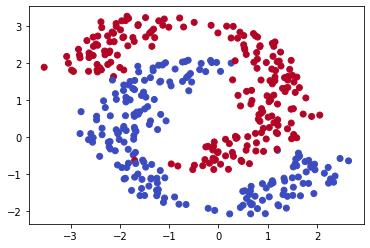

In [41]:
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train)

### Training

In [42]:
model = BinaryClassifier(n_features=2, degree=3)

In [43]:
model.fit(X_train, y_train, epochs=100, alpha=1)

Epoch 1/100
400/400 [==============] : loss = 0.763756	 acc = 0.4575
Epoch 2/100
400/400 [==============] : loss = 0.669095	 acc = 0.555
Epoch 3/100
400/400 [==============] : loss = 0.620445	 acc = 0.6175
Epoch 4/100
400/400 [==============] : loss = 0.589725	 acc = 0.655
Epoch 5/100
400/400 [==============] : loss = 0.567323	 acc = 0.6475
Epoch 6/100
400/400 [==============] : loss = 0.549595	 acc = 0.675
Epoch 7/100
400/400 [==============] : loss = 0.534875	 acc = 0.685
Epoch 8/100
400/400 [==============] : loss = 0.522272	 acc = 0.695
Epoch 9/100
400/400 [==============] : loss = 0.511251	 acc = 0.7
Epoch 10/100
400/400 [==============] : loss = 0.501465	 acc = 0.7125
Epoch 11/100
400/400 [==============] : loss = 0.492670	 acc = 0.7225
Epoch 12/100
400/400 [==============] : loss = 0.484691	 acc = 0.73
Epoch 13/100
400/400 [==============] : loss = 0.477393	 acc = 0.735
Epoch 14/100
400/400 [==============] : loss = 0.470673	 acc = 0.7475
Epoch 15/100
400/400 [==============] : 

Text(0.5, 1.0, 'Training Accuracy')

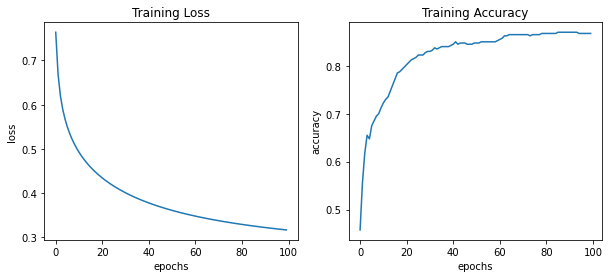

In [44]:
plt.figure(figsize=(10, 4))
plt.subplot(121)
plt.plot(model.metrics['loss_per_epochs'])
plt.xlabel('epochs')
plt.ylabel('loss')
plt.title('Training Loss')
plt.subplot(122)
plt.plot(model.metrics['acc_per_epochs'])
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.title('Training Accuracy')

In [45]:
min(model.metrics['loss_per_epochs'])

0.31708565555353563

In [46]:
model.get_weights()

{'weights': array([ 2.26563037,  0.8486111 , -0.73597703, -1.09508112, -1.99109305,
         2.42935218]),
 'bias': 0.13940158962618823}

### Evaluation

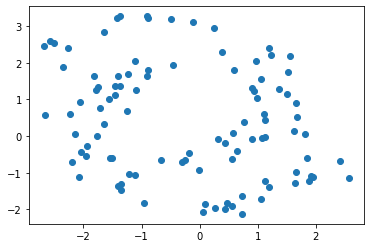

In [47]:
plt.scatter(X_test[:, 0], X_test[:, 1])

In [48]:
model.evaluate(X_test, y_test)

{'loss': 0.29554677662285167, 'accurracy': 0.89}

In [49]:
y_pred = model.predict(X_test, predict_classes=True)

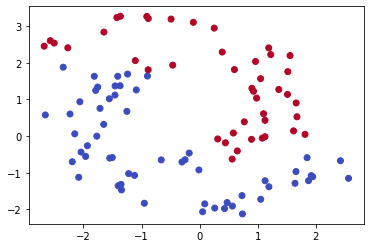

In [50]:
plt.scatter(X_test[:, 0], X_test[:, 1], c=y_pred)

### Decision Boundary

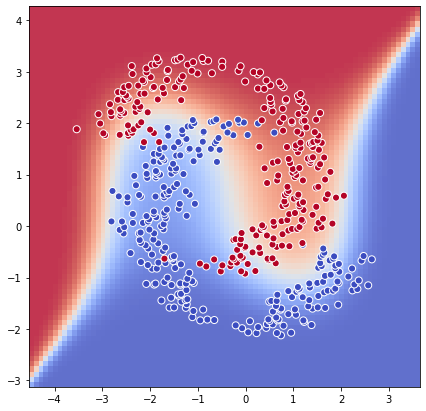

In [51]:
model.plot_decision_boundary(X, y)